# <center>Project 2 on Fuzzy system</center>

Subject: Application in medicine

Name: Hesam Mousavi

Student number: 9931155

Master student

<script type="text/x-mathjax-config">
MathJax.Hub.Config({
tex2jax: {
inlineMath: [['$','$'], ['\\(','\\)']],
processEscapes: true},
jax: ["input/TeX","input/MathML","input/AsciiMath","output/CommonHTML"],
extensions: ["tex2jax.js","mml2jax.js","asciimath2jax.js","MathMenu.js","MathZoom.js","AssistiveMML.js", "[Contrib]/a11y/accessibility-menu.js"],
TeX: {
extensions: ["AMSmath.js","AMSsymbols.js","noErrors.js","noUndefined.js"],
equationNumbers: {
autoNumber: "AMS"
}
}
});
</script>

In [1]:
import numpy as np
from my_io import read_dataset_to_X_and_y
from copy import deepcopy
import matplotlib.pyplot as plt

## Build Class to easily have all the variables

I like to have my variable all together so I build a class and named it
UniSet(short form of universal set)

Read dataset with my function on my_io module that can shuffle sample and
correct missing values also normalized the feature.  

In here I shuffle data and use class-mean for the missing values then
normalized it with the z-score method(zero-mean unit-variance)

I use all the features(12) and change sex from m, f to 0, 1 (actually I map
each string to a specific number in my_io module)


In [2]:
class UniSet():
    def __init__(self, file, range_feature, range_label,
                 normalization=None, shuffle=False, about_nan='class_mean'):
        np.random.seed(1)
        sample, label = read_dataset_to_X_and_y(
            file, range_feature, range_label, normalization, shuffle=shuffle,
            about_nan=about_nan)
        self.universal = sample.astype(float)
        self.label = label
        self.number_of_feature = sample.shape[1]
        self.size_of_universal = sample.shape[0]
        self.diffrent_label = np.unique(label)
        self.number_of_diffrent_label = self.diffrent_label.shape[0]
        self.relation = None
        self.equivalence_relation = None
        self.predicted_label = None
        self.diffrent_predicted_label = None
        self.number_of_diffrent_predicted_label = None


uni_total = UniSet(
    'dataset/hcvdat0.csv', (2, 14), (1, 2),
    normalization='z_score', shuffle=True, about_nan='class_mean')


print(f'The whole dataset is {uni_total.universal.shape} matrix')


The whole dataset is (615, 12) matrix


> #### Details 
>
> In my_io module I have a function named read_dataset_to_X_and_y
>  that get dataset file, range of attributes that are our features,
>  range of attributes that are our labels, normalization which is
>  our normalization method, shuffle which if be True our samples be
>  shuffled, and about_nan that can be "delete" which delete samples
>  with NA values or "class_mean" which replace NA values with mean of
>  that feature in the sample class
>
> Also as I mentioned above this function can get string attributes too
>  by mapping each string to a specific value so now our labels $\in [0, 4]$
>
> I change NA value with class-mean because It doesn't change the
>  similarity(or distance) of two samples in one class 
>
> In my class, I have all things that I'll need such as universal
>  (sample data), their label, number of features, size of universal
>  (dataset), different labels (unique labels), number of different labels,
>  a relation (on our universal set), and an equivalence relation.
>
> Our labels in this dataset is attributed [1, 2) and features are attributed
>  [2, 14) (12 features)


## Split the whole dataset to Train and Test

As I shuffle the dataset before, now I just consider the first 80%
of the data for the train and the rest for the test case



In [3]:
def split_train_test(universe: UniSet, train_size: float) -> list[UniSet]:
    train = deepcopy(universe)
    test = deepcopy(universe)
    train.size_of_universal = \
        int(universe.size_of_universal*train_size)
    train.universal = \
        universe.universal[0:train.size_of_universal]
    train.label = \
        universe.label[0:train.size_of_universal]
    test.size_of_universal = (
        universe.size_of_universal - train.size_of_universal)
    test.universal = \
        universe.universal[train.size_of_universal:]
    test.label = \
        universe.label[train.size_of_universal:]

    return train, test


uni_train, uni_test = split_train_test(uni_total, 0.8)
print(f'The train dataset is {uni_train.universal.shape} matrix')
print(f'The test dataset is {uni_test.universal.shape} matrix')


The train dataset is (492, 12) matrix
The test dataset is (123, 12) matrix


> #### Details 
>
> I create two classes for train and test by copying the total set and
just changing universal, level, and size of universal for both train and test

## Find relation matrix

To find the relation between each sample, first, we need metric for
similarity

### Similarity metric

First I find the distance between each pair of samples and, then
normalized it by dividing them to maximum distance, now all the
distances are between [0, 1] and now similarity is just equal to
1 - distance

$$
R\left(\mathbf{x}_{i}, \mathbf{x}_{k}\right)=1-\delta\left
(\sum_{j=1}^{p}\left|x_{i j}-x_{k j}\right|^{q}\right)^{\frac{1}{q}}
$$
which $\delta$ is maximum distance 


In [4]:
def distance(sample1: np.ndarray, sample2: np.ndarray) -> float:
    return np.linalg.norm(sample1-sample2)


def find_relation(universal: UniSet) -> np.ndarray:
    dis = np.array(
        list(map(lambda x: list(map(
            lambda y: distance(
                universal.universal[x], universal.universal[y]),
            range(universal.size_of_universal))),
            range(universal.size_of_universal))))
    return 1 - dis / np.max(dis)


uni_train.relation = find_relation(uni_train)
print(f'The relation on train dataset is {uni_train.relation.shape} matrix')


uni_test.relation = find_relation(uni_test)
print(f'The relation on test dataset is {uni_test.relation.shape} matrix')


The relation on train dataset is (492, 492) matrix
The relation on test dataset is (123, 123) matrix


> #### Details 
>
> Our Similarity metric has some properties:
>
> Similarity $(x, y) \in[0,1]$
>
> Similarity $(x, x)=1$
>
> Similarity $(x, y)=$ Similarity $(y, x)$


## How to make a relation transitive?

I use the following algorithm to find a transitive closure of a relation.

1. $R^{\prime}=R \cup(R \circ R)$.
2. If $R^{\prime} \neq R$, make $R=R^{\prime}$ and go to Step 1 .
3. Stop: $R^{\prime}=R_{T}$.


In [5]:
def max_min(sample1: np.ndarray, sample2: np.ndarray) -> float:
    both_sample = np.vstack((sample1, sample2))
    return np.max(np.min(both_sample, axis=0))


def composition_RoR(relation: np.ndarray) -> np.ndarray:
    result = np.array(
        list(map(lambda x: list(map(
            lambda y: max_min(relation[x], relation[y]),
            range(relation.shape[0]))),
            range(relation.shape[0]))))
    return result


def union_two_relation(
        relation1: np.ndarray, relation2: np.ndarray) -> np.ndarray:
    both_relation = np.dstack((relation1, relation2))
    return np.max(both_relation, axis=2)


def make_transitive(relation: np.ndarray) -> np.ndarray:
    R = None
    Rp = np.copy(relation)
    iter = 0
    while((Rp != R).any()):
        R = np.copy(Rp)
        RoR = composition_RoR(R)
        Rp = union_two_relation(R, RoR)
        iter += 1
        print(iter)
    return Rp


print('#Iteration to make train relation transitive')
uni_train.equivalence_relation = make_transitive(uni_train.relation)
print('The equivalence relation on train dataset is',
        f'{uni_train.equivalence_relation.shape} matrix')

print('\n#Iteration to make test relation transitive')
uni_test.equivalence_relation = make_transitive(uni_test.relation)
print('The equivalence relation on test dataset is',
        f'{uni_test.equivalence_relation.shape} matrix')


#Iteration to make train relation transitive
1
2
3
4
5
6
The equivalence relation on train dataset is (492, 492) matrix

#Iteration to make test relation transitive
1
2
3
4
5
The equivalence relation on test dataset is (123, 123) matrix


> #### Details 
>
> Order of max-min is $O\left(n\right)$ and in composition R and R
>  we compose each pair of sample ($O\left(n^{2}\right)$) with max-min
>  so function composition_RoR has order $O\left(n^{3}\right)$. To
>  make relation transitive we need to compose our result 
> $\lg \left(\left\lceil\frac{n}{2}\right\rceil\right)$ to find transitive 
> relation along the longest path so out algotrithm is $O\left(n^{3} \lg n\right)$


## Equivalence relation

Before find similar classes, we must find equivalence relation
(be reflexive, symmetric, and transetive) to be sure If
$R(x, y) \geqslant \alpha$ and
$R(y, z) \geqslant \alpha \Rightarrow R(x, z) \geqslant \alpha$ 
which cause all pairs in similarity class have similarity
$\geqslant \alpha$ (transitive) and $R(x, y) = R(y, x)$ to be sure
if x and y is in same class y and x can be in same class (symmetric)
and $R(x, y) = 1$ to be sure x and x can be in a same similarity class (reflexive).

By having all three property we sure that every element in a
specific similarity class (cluster) have the same similarity class.

### Reflexive

Base on our similatiry metric, $similarity(x, x) = 1$ because
distance x and x is zero and zero devided by any number is still
zero and finally $1 - 0 = 1$ and for checking that our relation
is reflexive we only need to check if $diag(R) = \vec1$

### Symmetric

Base on our similatiry metric, $similarity(x, y) = similarity(y, x)$
because only variable in our metric is distance and by using lebesgue
norm, distance x from y is equal to distance y from x
$\Rightarrow similarity(x, y) = similarity(y, x)$ and for checking that
our relation is symmetric we only need to check if $R = R^\intercal$

### Transitive

With the above algorithm (in the previous cell) we make our relation
transitive and for checking that our relation is transitive we only
need to check if $R=R \cup(R \circ R)$.


In [6]:
def is_reflexive(relation: np.ndarray) -> bool:
    return (relation.diagonal() == 1).all()


def is_symmetric(relation: np.ndarray) -> bool:
    return (relation == relation.T).all()


def is_transitive(relation: np.ndarray) -> bool:
    RoR = composition_RoR(relation)
    Rp = union_two_relation(relation, RoR)
    return (Rp == relation).all()


def is_equivalece(relation: np.ndarray) -> bool:
    return is_reflexive(relation) & is_symmetric(relation) & \
        is_transitive(relation)


print('Is our train equivalence relation, equivalence?',
    f'{is_equivalece(uni_train.equivalence_relation)}')

print('Is our test equivalence relation, equivalence?',
    f'{is_equivalece(uni_test.equivalence_relation)}')


Is our train equivalence relation, equivalence? True
Is our test equivalence relation, equivalence? True


> #### Details 
>
> For checking if our relation is equivalence we should check to
>  be reflexive, symmetric, and transitive


## Clustering

With our equivalence similarity relation, we can cluster our data
by finding similarity classes and as our relation is equivalent
if we find similarity class for sample x, we don't need to find
the equivalent class for the other members of equivalence class x
because as I proof before all of them has the same equivalence
class as x so we'll cluster the equivalence class for x and then
cluster rest of the data


In [7]:
def find_similarity_class(
        universal: UniSet, target_sample: int, alpha: float) -> np.ndarray:
    size_of_universal = universal.shape[0]
    similarity_class = []
    for sample in range(size_of_universal):
        if(universal[sample, target_sample] >= alpha):
            similarity_class.append(sample)
    return np.array(similarity_class)


def find_cluster(relation: np.ndarray, alpha: float, label=False):
    size_of_universal = relation.shape[0]
    classes = []
    predicted_label = np.full((size_of_universal, 1), -1.0)
    number_of_class = 0.0
    for sample in range(size_of_universal):
        if(predicted_label[sample] == -1):
            new_class = find_similarity_class(relation, sample, alpha)
            predicted_label[new_class] = number_of_class
            number_of_class += 1
            classes.append(new_class)
    number_of_class = int(number_of_class)
    if(label is True):
        return predicted_label, number_of_class
    return classes, number_of_class


cluster_alpha_cut_93 = find_cluster(uni_train.equivalence_relation, 0.93)
print('\nCluster with alpha-cut 0.93 on train equivalence relation is')
print(cluster_alpha_cut_93)


Cluster with alpha-cut 0.93 on train equivalence relation is
([array([  0,   1,   3,   6,   8,  12,  13,  14,  15,  16,  17,  20,  22,
        31,  41,  44,  45,  46,  47,  49,  52,  57,  58,  59,  60,  66,
        67,  76,  78,  79,  80,  82,  85,  89,  98, 101, 105, 107, 112,
       128, 142, 144, 146, 153, 154, 161, 164, 168, 171, 172, 173, 175,
       176, 178, 180, 185, 186, 190, 195, 197, 200, 203, 210, 214, 222,
       223, 224, 226, 227, 228, 229, 231, 232, 234, 236, 238, 242, 243,
       244, 245, 250, 253, 255, 258, 263, 264, 265, 266, 267, 272, 275,
       276, 279, 284, 285, 288, 290, 291, 293, 295, 297, 299, 302, 305,
       312, 313, 314, 316, 317, 322, 324, 326, 327, 328, 330, 332, 333,
       337, 340, 347, 349, 355, 359, 360, 361, 364, 367, 370, 371, 376,
       381, 382, 383, 388, 395, 398, 413, 423, 427, 437, 439, 441, 442,
       444, 445, 446, 448, 450, 452, 462, 463, 466, 469, 470, 480, 481,
       489, 490]), array([  2,   4,   7,   9,  10,  11,  18,  19,  23,  

> #### Details 
>
> ##### Function find_similarity_class
>
> Get a relation, sample, and $\alpha$ then find similarity class 
> for that sample by selecting all samples that have similarity 
> $\geqslant \alpha$ with our sample and return a crisp set ([x])
>
> ##### Function find_cluster
>
> Get relation, $\alpha$, and label then find clusters which in each
>  cluster all pair of members have similarity $\geqslant \alpha$.
>  first, all the elements are in cluster -1 (not clustered yet) and
>  every time we select a member of cluster -1 and find its similarity
>  class and create a new cluster with all elements of similarity class
>  and remove them from cluster -1. cluster are labeled from 0 and if
>  label=True our funcion retun vector predicted-label which is predicted
>  label for all samples and if label=False return set of clusters


## Which $\alpha$-cut clustering our data better

I find all unique membership degrees in our equivalent relation then
start from smallest to the biggest and check my accuracy of clustering
with that membership degree if $\nabla$ degree $\geqslant \varepsilon$
(with the last degree that I checked) and select the $\alpha$ which
split our data into the number of different labels (i.e. 5 in our dataset)
as the best $\alpha$-cut

### Accuracy

I use **Confusion matrix** to find the label of clusters (argmax in each row)
and then choose f1-score as accuracy metric because as $\alpha$ increase
precision increase and recall decrease and I want to find $\alpha$ that satisfy both


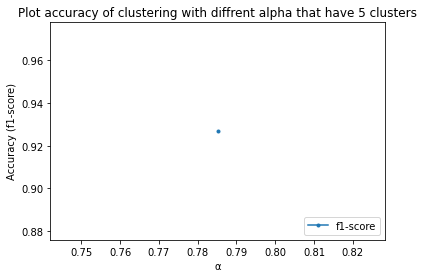

Best alpha-cut is 0.7852 on train-dataset with f1-score 92.69%


In [8]:
def evaluate(gold_label: np.ndarray, predict_label: np.ndarray,
             method: str = 'f1-score') -> float:
    diffrent_label_in_gold_label = np.unique(gold_label)
    diffrent_label_in_predict_label = np.unique(predict_label)
    confusion_matrix = np.array(
        list(map(lambda k: list(map(
            lambda s: sum((predict_label == k)*(gold_label == s))[0],
            diffrent_label_in_gold_label)),
            diffrent_label_in_predict_label)))
    precision = np.sum(
        np.max(confusion_matrix, axis=1)) / np.sum(confusion_matrix)
    recall = np.sum(
        np.max(confusion_matrix, axis=0)) / np.sum(confusion_matrix)
    if(method == 'precision'):
        return precision
    if(method == 'recall'):
        return recall
    if(method == 'f1-score'):
        return 2 * ((precision*recall)/(precision+recall))


def find_best_alpha_cut(universal: UniSet, plotter: bool = False) -> float:
    alpha_cut = []
    accuracy = []
    last_point = -1.0
    for alpha in np.unique(universal.equivalence_relation):
        if(alpha - last_point >= 0.0001):
            alpha_clustered_label, alpha_number_of_class = find_cluster(
                universal.equivalence_relation, alpha, True)
            if(alpha_number_of_class == universal.number_of_diffrent_label):
                alpha_cut.append(alpha)
                accuracy.append(evaluate(universal.label, alpha_clustered_label))
            elif(alpha_number_of_class > universal.number_of_diffrent_label):
                break
            last_point = alpha
    
    if(plotter is True):
        plt.plot(alpha_cut, accuracy, '.-', label="f1-score")
        plt.legend(loc="lower right")
        plt.xlabel('α')
        plt.ylabel('Accuracy (f1-score)')
        plt.title((
            f'Plot accuracy of clustering with diffrent alpha that have '
            f'{universal.number_of_diffrent_label} clusters'))
        plt.show()
    
    return alpha_cut[np.argmax(accuracy)], np.max(accuracy)


best_alpha_cut, best_alpha_cut_accuracy = find_best_alpha_cut(uni_train, True)
print(f'Best alpha-cut is {round(best_alpha_cut, 4)} on train-dataset',
        f'with f1-score {round(best_alpha_cut_accuracy*100, 2)}%')

uni_train.predicted_label = find_cluster(
    uni_train.equivalence_relation, best_alpha_cut, True)[0]
uni_train.diffrent_predicted_label = np.unique(uni_train.predicted_label)
uni_train.number_of_diffrent_predicted_label = \
    uni_train.diffrent_predicted_label.shape[0]

> #### Details 
> 
> Set $\varepsilon = 0.0001$ and when the number of clusters with our 
> $\alpha$-cut cause more than different labels that we have, I stop 
> because after that by increasing $\alpha$ value we get more number 
> of clusters and we want to find the most accurate $\alpha$ that 
> create clusters with number of our different labels
> 
> ##### Confusion matrix
> 
> <p align="center">
>  <img src="report/confusion-matrix.png", width="500">
> </p>
> 
> Its $(K * S)$ matrix that $a_{k, s}=$ total number of samples clustered
>  to the kᵗʰ cluster and belongs to the sᵗʰ class.
>  $$\text { Precision }=\frac{\sum_{k}
\max _{s}\left\{a_{k s}\right\}}{\sum_{k} \sum_{s} a_{k s}}$$
>  $$\operatorname{Recall}=\frac{\sum_{s}
\max _{k}\left\{a_{k s}\right\}}{\left(\sum_{k} \sum_{s} a_{k s}+U\right)}$$
>  $$F1-score=2 \times \frac{\text
{ Precision } \times \text { Recall }}{\text { Precision }+\text { Recall }}$$


## Let's test our $\alpha$

To do that we use our test set, find relation on the test set and make it transitive to be equivalence relation and then find our clusters with $\alpha$-cut than we find in the training phase the compute test accuracy to see how well our $\alpha$-cut works on the test set


In [9]:
predicted_label_test = find_cluster(
    uni_test.equivalence_relation, best_alpha_cut, True)[1]
test_accuracy = evaluate(uni_test.label, predicted_label_test)
print('Our f1-score on test-dataset with best alpha-cut on train-set is ',
        f'{round(test_accuracy*100, 2)}%')

Our f1-score on test-dataset with best alpha-cut on train-set is  93.97%


## $R_{o}$

Occurrence relation: knowledge about the tendency or frequency of appearance of a symptom
when the specific disense is present - "How often does symptoms occur with disease d?"

Its a matrix (symptom, disease) and I use the average of each symptom for each disease

In [10]:
def find_Ro(universal: UniSet):
    ro = []
    for a_disease in universal.diffrent_predicted_label:
        class_label = universal.universal[(universal.predicted_label == a_disease).flatten()]
        mean_symptom_a_disease = np.mean(class_label, axis=0)
        ro.append(mean_symptom_a_disease)
    ro = np.array(ro).T
    
    return ro


R_o = find_Ro(uni_train)
print(f'The R0 is {R_o.shape} matrix')

The R0 is (12, 5) matrix


> #### Details 
> 
> Here I use predicted label from clustering with our best $\alpha$-cut on equivalence relation

## $R_{1}$

$R_{1}=R_{s} \circ R_{o}$ and Its a matrix (patient, disease)

Then I select the most value as a disease for each patient which is a matrix (patient, 1)

In [11]:
def composition_RoS(relation_r: np.ndarray, relation_s: np.ndarray) -> np.ndarray:
    result = np.array(
        list(map(lambda x: list(map(
            lambda y: max_min(relation_r[x], relation_s.T[y]),
            range(relation_s.shape[1]))),
            range(relation_r.shape[0]))))
    return result

R_1 = composition_RoS(uni_test.universal, R_o)
print(f'The R1 is {R_1.shape} matrix')

disease_test = np.argmax(R_1, axis=1).reshape((-1, 1))
print(f'The disease_test is {disease_test.shape} matrix')

disease_test_accuracy = evaluate(uni_test.label, disease_test, 'precision')
print('Our precision on disease_test from R1 is ',
        f'{round(disease_test_accuracy*100, 2)}%')

The R1 is (123, 5) matrix
The disease_test is (123, 1) matrix
Our precision on disease_test from R1 is  89.43%


## $R_{c}$

Confirmability relation: the discriminating power of the symptom to confirm the presence of
the disease - "How strongly does symptoms confirm disease d?"

# <center>Thanks for your time</center>